##### What is this notebook about?
- This notebook shows how to implement key components of following LLM models from scratch in Pytorch to understand the concepts
    - GPT-2
    - LLama-2
    - Llama-3, 3.1, 3.2
- Some key components are:
    - Tokenization 
        - BPE: GPT-2, Llama-3* models
        - SentencePiece: Llama-2 model
    - Token Embeddings layer
        - Weight tying between input & output embedding layers: GPT-2, Llama-3.2
    - Transformer block
        - Attention mechanism
            - Multi-head attention (MHA) + Causal attention (since Decoder only model)
                - Additional optimizations?
                    - None: GPT-2
                    - Group query attention (GQA): Llama-3
            - Positional embeddings
                - Absolute, learnable: GPT-2
                - Rotary (RoPE): Llama-2,3* models
                    - RoPE rescaling factor / inverse frequency changes: Llama-3.1, 3.2
        - Feedforward network (FFN)
            - Activation function 
                - GELU: GPT-2
                - SiLU/SwiGLU: Llama-2,3* models
        - Activation Normalization 
            - LayerNorm: GPT-2
                - Pre-LayerNorm: LayerNorm, MHA, Dropout --> LayerNorm, FFN, Dropout
                - Post-LayerNorm: MHA, FFN, LayerNorm, Dropout
            - RMSNorm: Llama-2,3* models
        - Skip/Shortcut connections
        - Dropout
    - Final output layer
        - Activation normalization
            - LayerNorm: GPT-2
        - Token Embeddings layer

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math

torch.manual_seed(2024)



### LayerNorm (vs) RMSNorm
- Why LayerNorm instead of BatchNorm: 
    - Make it robust to training batch size or seq length changes, and also easier to parallelize (no sync required across devices)
- Why RMSNorm
    - Only 1 learnable parameter => faster

In [2]:
# 2 parameters: scale, shift
class LayerNorm(nn.Module):
    def __init__(self, dim, eps):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))
        self.shift = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # unbiased False => No Bessel's correction => variance formula has divide by n (not n-1)
        norm = (x - mean) / torch.sqrt(var + self.eps)
        ln = self.scale*norm + self.shift
        return ln

# 1 parameter: scale (no mean shift)
class RMSNorm(nn.Module):
    def __init__(self, dim, eps):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))
        
    def forward(self, x):
        mean = x.pow(2).mean(dim=-1, keepdim=True)
        norm = x * torch.rsqrt(mean + self.eps)
        rn = self.scale*norm
        return rn


In [3]:
x = torch.randn(2, 3, 4) # bs, seq_len, dim
print(x)

# LayerNorm
lnorm = LayerNorm(dim=x.shape[-1], eps=1e-5)
lnorm_pt = nn.LayerNorm(x.shape[-1], eps=1e-5)
x_lnorm = lnorm(x)
x_lnorm_pt = lnorm_pt(x)
print("\nLayerNorm")
print(x_lnorm)
eq = torch.allclose(x_lnorm, x_lnorm_pt)
print(eq)

# RMSNorm
rms_norm = RMSNorm(dim=x.shape[-1], eps=1e-5)
rms_norm_pt = nn.RMSNorm(x.shape[-1], eps=1e-5)
x_rms_norm = rms_norm(x)
x_rms_norm_pt = rms_norm_pt(x)
print("\nRMSNorm")
print(x_rms_norm)
eq = torch.allclose(x_rms_norm, x_rms_norm_pt)
print(eq)

tensor([[[-1.2262, -0.0093,  1.5420, -0.4657],
         [ 0.2795, -0.2610,  0.6230, -1.1561],
         [ 0.7131, -0.3869, -0.2535, -1.6675]],

        [[-0.3712,  0.1377, -0.5199, -0.3497],
         [-0.0776, -1.1175, -0.6481,  0.6530],
         [-0.1596,  0.3569,  0.6595, -0.1452]]])

LayerNorm
tensor([[[-1.1730,  0.0302,  1.5639, -0.4210],
         [ 0.6076, -0.1970,  1.1190, -1.5296],
         [ 1.3132,  0.0139,  0.1715, -1.4986]],

        [[-0.3854,  1.6701, -0.9862, -0.2985],
         [ 0.3328, -1.2407, -0.5304,  1.4383],
         [-0.9719,  0.5154,  1.3870, -0.9304]]], grad_fn=<AddBackward0>)
True

RMSNorm
tensor([[[-1.2114, -0.0092,  1.5234, -0.4601],
         [ 0.4087, -0.3816,  0.9109, -1.6904],
         [ 0.7620, -0.4135, -0.2709, -1.7819]],

        [[-1.0016,  0.3717, -1.4029, -0.9435],
         [-0.1071, -1.5418, -0.8942,  0.9009],
         [-0.4090,  0.9147,  1.6904, -0.3720]]], grad_fn=<MulBackward0>)
True


### GELU (vs) SiLU
- Rectified Linear Unit (ReLU): 
    - Used in vanilla transformers. Dying gradients for negative activations. 
- Gaussian Error Linear Unit (GELU): 
    - Used in GPT-2. Smoother
- Sigmoid weighted Linear Unit (SiLU): 
    - More smooth. Used inside FFN of Llama-2,3* models

In [4]:
class Sigmoid(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return 1./(1 + torch.exp(-x))

class Tanh(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return torch.tanh(x)
    
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.maximum(x, torch.tensor(0.0))
    
class LeakyReLU(nn.Module):
    def __init__(self, negative_slope=1e-2):
        super().__init__()
        self.negative_slope = negative_slope

    def forward(self, x):
        return torch.where(x > 0, x, self.negative_slope * x)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # approximation of x.cdf(N(x))
        return 0.5*x*(
                    1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3)))
                    )

class SiLU(nn.Module):
    def __init__(self,):
        super().__init__()
        
    def forward(self, x):
        return x * torch.sigmoid(x)

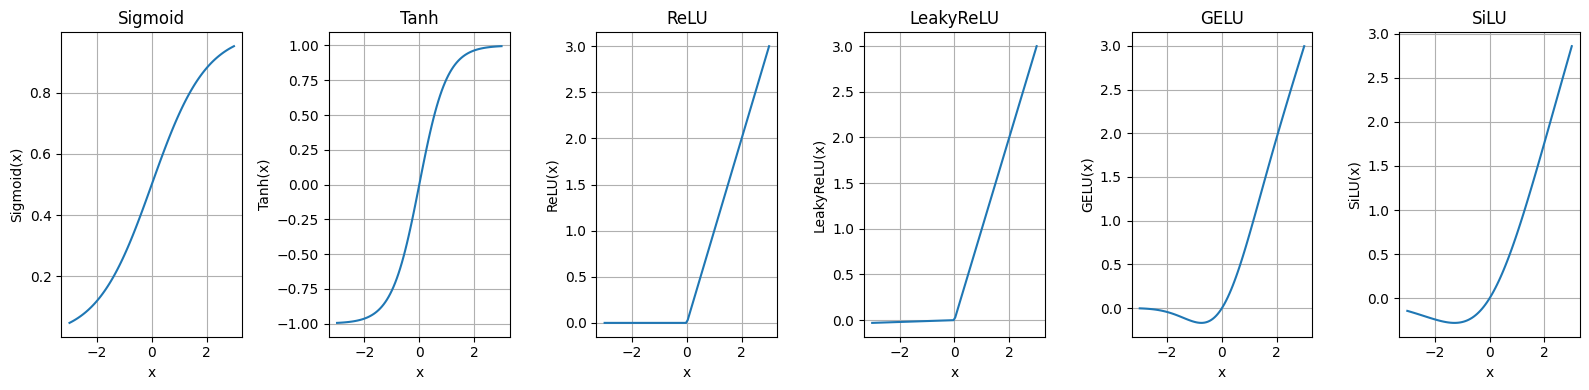

In [5]:
sigmoid, tanh, relu, lrelu, gelu, silu = Sigmoid(), Tanh(), ReLU(), LeakyReLU(), GELU(), SiLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_sigmoid, y_tanh, y_relu, y_lrelu, y_gelu, y_silu = sigmoid(x), tanh(x), relu(x), lrelu(x), gelu(x), silu(x)

plt.figure(figsize=(16, 4))
for i, (y, label) in enumerate(zip([y_sigmoid, y_tanh, y_relu, y_lrelu, y_gelu, y_silu], ["Sigmoid", "Tanh", "ReLU", "LeakyReLU", "GELU", "SiLU"]), 1):
    plt.subplot(1, 6, i)
    plt.plot(x, y)
    plt.title(f"{label}")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
if False:
    
    x = torch.randn(2, 3, 4) # bs, seq_len, dim
    print(f"{x}\n")

    x_act_tuples = [("Sigmoid", sigmoid(x), nn.functional.sigmoid(x)), 
                    ("Relu", relu(x),  nn.functional.relu(x)), 
                    ("LeakyRelu", lrelu(x), nn.functional.leaky_relu(x)),
                    ("Gelu", gelu(x), nn.functional.gelu(x)),
                    ("Silu", silu(x), nn.functional.silu(x))]

    for activation_name, x_c, x_pt in x_act_tuples:
        print(f"{activation_name}")
        print(x_c)
        eq = torch.allclose(x_c, x_pt)
        print(f"{eq}\n")

### Feedforward layer: Regular FFN (vs) SwiGLU FFN
- Regular FFN:
    - Uses GELU actvn
    - Used in Vanilla transformer, GPT-2
- SwiGLU FFN: 
    - Applies Gated Linear Unit (GLU), i.e gate the input
    - Uses SiLU actvn.
    - Used in Llama-2,3* models

In [7]:
# Regular FFN with GELU actvn
class FFN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        hidden_dim = 4*dim
        self.layers = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.layers(x)

# SwiGLU FFN with SiLU actvn
class FFNSwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, dtype=None, bias=False):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim, dtype=dtype, bias=bias)
        self.fc2 = nn.Linear(dim, hidden_dim, dtype=dtype, bias=bias)
        self.fc3 = nn.Linear(hidden_dim, dim, dtype=dtype, bias=bias)
        self.silu = SiLU()

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = self.silu(x_fc1) * x_fc2
        return self.fc3(x)

In [8]:
x = torch.randn(2, 3, 4) # bs, seq_len, dim
print(x)

# Regular FFN
ffn = FFN(dim=x.shape[-1])
x_op = ffn(x)
print("\nReg FFN")
print(x_op)

# SwiGLU FFN
ffn_swiglu = FFNSwiGLU(dim=x.shape[-1], hidden_dim=x.shape[-1]*4)
x_op = ffn_swiglu(x)
print("\nSwiGLU FFN")
print(x_op)

tensor([[[ 0.0306, -0.5932, -0.5154,  0.5214],
         [-0.3626, -1.0657, -0.1616, -2.6492],
         [ 0.3171, -1.8716, -0.0894,  0.7485]],

        [[ 0.6137, -0.4419,  0.0984, -0.1520],
         [-0.5458,  0.9425,  0.3299,  1.5264],
         [-0.1864,  0.9193, -0.3248,  1.3998]]])

Reg FFN
tensor([[[-0.0851,  0.1634,  0.2544,  0.0912],
         [-0.0408,  0.8007, -0.0245,  0.1304],
         [-0.3139,  0.1388,  0.3955,  0.0671]],

        [[-0.1838,  0.1320,  0.1881,  0.1824],
         [-0.0194,  0.0916, -0.2381,  0.1762],
         [-0.0885,  0.1518, -0.1587,  0.1018]]], grad_fn=<ViewBackward0>)

SwiGLU FFN
tensor([[[ 0.0034,  0.0133,  0.0156,  0.0053],
         [-0.3016, -0.1899,  0.0846, -0.1377],
         [ 0.0138,  0.1793,  0.0284,  0.0598]],

        [[-0.0026,  0.0154,  0.0082,  0.0215],
         [-0.0113,  0.0069,  0.0409, -0.0247],
         [-0.0609, -0.0304,  0.0311, -0.0298]]], grad_fn=<UnsafeViewBackward0>)


### Positional encodings & embeddings: Absolute (vs) Relative (vs) Rotary (RoPE)
- Note: Assume model's embedding dimension is $dim$
- Absolute positional encodings
    - Does not explicitly encode relative position info
    - Could be fixed embeddings or learnable embeddings
        - Fixed sinusoidal embeddings (no parameters): 
            - Used in Vanilla transformer
                - ${\theta_i = \frac{1}{10000^{\frac{2i}{dim}}}, i \in [0, 1, ..., \frac{dim}{2}-1]}$
                - $PE_{(pos,2i)} = sin(pos*\theta_i)$, $PE_{(pos,2i + 1)} = cos(pos * \theta_i)$
                    - Wavelength of $sin(pos*c)$ is $\frac{2\pi}{c}$. 
                    - So, Wavelength of the sinusoid at PE's $2i$ th & $(2i+1)$ th dimensions is $2\pi*{10000^{\frac{2i}{dim}}}$ 
                    - Example wavelengths:   
                        - At $0$, $1$ dimensions => $2\pi$
                        - At $2$, $3$ dimensions => $2\pi*{10000^{\frac{2}{dim}}}$
                        - At ${(dim - 1)}^{th}$, ${dim}^{th}$ dimension => $2\pi*10000$
        - Learnable embeddings
            - Used in GPT-2
- Relative positional embeddings
    - Explicitly encodes relative position info
    - Fixed sinusoidal embeddings + Learnable relative embedding (2 parameters)
    - Used in Transformer-XL
- Rotary positional embeddings (RoPE)
    - Explicitly encodes both absolute & relative position info
    - Used in most SOTA LLMs - Llama2,3*, Mistral, etc.
    - Fixed rotation matrix (no parameters)
        - Idea: 
            - Rotate 2d embedding at position $m$ by $m\theta$. 
                - $RoPE[x_{(m,1)}, x_{(m,2)}]$ =
                \begin{pmatrix}
                x_{(m,1)} \cos m\theta - x_{(m,2)} \sin m \theta \\
                x_{(m,2)} \cos m\theta + x_{(m,1)} \sin m \theta \\
                \end{pmatrix} \\  

            - For 2 embeddings $x_m$ and $x_n$ at positions $m$ and $n$, 
                - Dot product of $x_m$ and $x_n$ = Dot product of $x_{m-n}$ and $x_0$
                - So, attention on RoPE embeddings is relative
        - Implementation: 
            - Rotate every pair of dims in input embedding $x_m$ by $m{\theta_i}$. So $dim$ should be multiple of 2.
                - Pair $i$ and $(i+\frac{dim}{2})$ dimensions. 
                - ${\theta_i = \frac{1}{10000^{\frac{2i}{dim}}}, i \in [0, 1, ..., (\frac{dim}{2}-1)]}$ 
                - for $i \in {0, 1, ..., (\frac{d}{2}-1)}$: 
                    - $RoPE[x_{(m,i)}, x_{(m,(i+\frac{dim}{2}))}]$ =  
                    \begin{pmatrix}
                    x_{(m,i)}  \cos m \theta_i - x_{(m,(i + \frac{dim}{2}))} \sin m \theta_i \\
                    x_{(m,(i + \frac{dim}{2}))} \cos m\theta_i + x_{(m,i)} \sin m \theta_i \\
                    \end{pmatrix} \\


torch.Size([100, 64])
torch.Size([2, 3, 64])


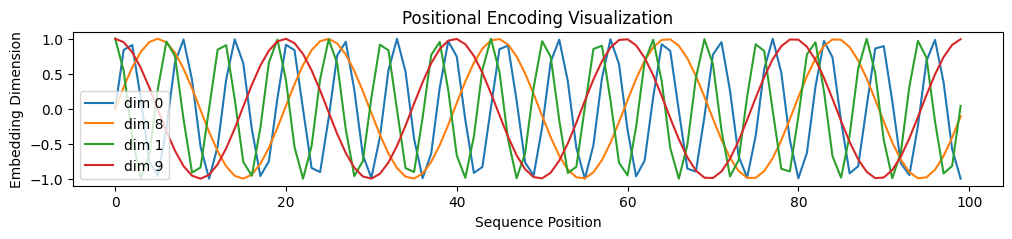

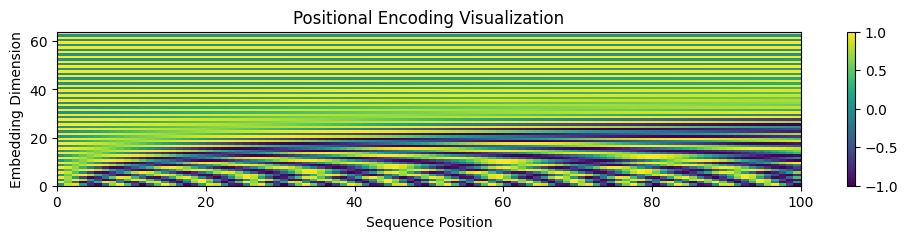

In [9]:
# Absolute fixed positional encoding

class AbsoluteFixedPositionalEncoding(nn.Module):

    def __init__(self, seq_len, dim, theta_base=10000.0):

        super().__init__()
        pe = torch.zeros(seq_len, dim)
        positions = torch.arange(0, seq_len).unsqueeze(1).float() # seq_len
        two_i = torch.arange(0, dim, 2, dtype=torch.float) # dim/2
        theta = torch.exp(two_i * -(math.log(theta_base) / dim)) # dim/2
        angles = positions * theta # (seq_len, dim/2)
        pe[:, 0::2] = torch.sin(angles)
        pe[:, 1::2] = torch.cos(angles)
        pe = pe.unsqueeze(0)  # (1, seq_len, dim)
        self.register_buffer("pe", pe)

    def forward(self, x):
        bs, seq_len, dim = x.size()
        x = x + self.pe[:, :seq_len]
        return x
   
theta_base = 10000.0
seq_len = 100
dim = 64
pe_layer = AbsoluteFixedPositionalEncoding(seq_len, dim, theta_base)
pe = pe_layer.pe[0] # (seq_len, dim)
print(pe.shape)
x = torch.randn(2, 3, dim) # bs, seq_len, dim
x = pe_layer(x)
print(x.shape)

# Plot few dimensions
plt.figure(figsize=(12, 2))
positions_sin = range(0,16,8)
positions_cos = range(1,16,8)
plt.plot(np.arange(seq_len), pe[:seq_len, positions_sin].numpy())
plt.plot(np.arange(seq_len), pe[:seq_len, positions_cos].numpy())
plt.legend(["dim %d" % p for p in list(positions_sin) + list(positions_cos)])
plt.xlabel("Sequence Position")
plt.ylabel("Embedding Dimension")
plt.title("Positional Encoding Visualization")
plt.show()

# Plot all embeddings
plt.figure(figsize=(12, 2))
plt.pcolormesh(pe.T, cmap='viridis')
plt.colorbar()
#cax = plt.matshow(pe)
#plt.gcf().colorbar(cax)
plt.xlabel("Sequence Position")
plt.ylabel("Embedding Dimension")
plt.title("Positional Encoding Visualization")
plt.show()


In [10]:
# Absolute + Learnable positional embeddings
class AbsoluteLearnablePositionalEmbedding(nn.Module):

    def __init__(self, seq_len, dim):
        super().__init__()
        self.pe = nn.Embedding(seq_len, dim)

    def forward(self, x):
        bs, seq_len, dim = x.size()
        x = x + self.pe(torch.arange(seq_len))
        return x
   
seq_len = 100
dim = 64
pe_layer = AbsoluteLearnablePositionalEmbedding(seq_len, dim)
pe = pe_layer.pe # (seq_len, dim)
print(pe.weight.shape)
x = torch.randn(2, 3, dim) # bs, seq_len, dim
x = pe_layer(x)
print(x.shape)

torch.Size([100, 64])
torch.Size([2, 3, 64])


In [11]:
if 0:
    
    # Relative positions embeddings (inspired from transformer-xl)
    class RelativePositionalEmbeddings(nn.Module):
    
        def __init__(self, seq_len, dim, theta_base=10000):

            super().__init__()
            positions = torch.arange(seq_len - 1, -seq_len, -1.0).float()  # 2*seq_len-1
            two_i = torch.arange(0, dim, 2.0, dtype=torch.float) # dim/2
            theta = 1 / (theta_base ** (two_i / dim)) # dim/2
            angles = torch.ger(positions, theta) # (2*seq_len-1, dim/2)
            pe = torch.cat([angles.sin(), angles.cos()], dim=-1) # (2*seq_len-1, dim)            
            self.register_buffer("pe", pe)
            self.max_len = seq_len

        def forward(self, x):
            bs, seq_len, dim = x.size()
            zero_ix = self.max_len - 1
            lix = zero_ix - (seq_len - 1)
            rix = zero_ix + (seq_len - 1) + 1
            pe = self.pe[lix:rix, :]
            # TBD rest of it
            return pe

    theta_base = 10000.0
    seq_len = 100
    dim = 64
    pe_layer = RelativePositionalEmbeddings(seq_len, dim, theta_base)
    pe = pe_layer.pe[0] # (seq_len, dim)
    print(pe.shape)
    x = torch.randn(2, 3, dim) # bs, seq_len, dim
    x = pe_layer(x)
    print(x.shape)

In [ ]:
# Rotary positional embeddings (RoPE)
class RotaryPositionalEmbeddings(nn.Module):

    def __init__(self, seq_len, dim, theta_base=10000, rope_config=None):
        super().__init__()
        positions = torch.arange(seq_len).float()
        two_i = torch.arange(0, dim, 2, dtype=torch.float)
        theta = 1. / (theta_base ** (two_i / dim))
        angles = positions[:, None] * theta[None, :] # (seq_len, dim/2)
        # or angles = torch.outer(positions, theta)  
        # or torch.ger(positions, theta)  
        # or angles = torch.einsum('n,d->nd', positions, theta)  
        angles2 = torch.cat([angles, angles], dim=1) # (seq_len, dim)    
        cos = torch.cos(angles2) # (1, 1, seq_len, dim)
        sin = torch.sin(angles2) # (1, 1, seq_len, dim) 
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)

    def forward(self, x):
        half_dim = dim // 2
        seq_len = x.shape[2]
        x1 = x[:, :, :, :half_dim] # (bs, num_heads, seq_len, dim/2)
        x2 = x[:, :, :, half_dim:] # (bs, num_heads, seq_len, dim/2)
        neg_half_x = torch.cat([-x2, x1], dim=-1) # (bs, num_heads, seq_len, dim)
        cos = self.cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, head_dim)
        sin = self.sin[:seq_len, :].unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, dim)      
        x_rope = (x * cos) + (neg_half_x * sin) # (bs, num_heads, seq_len, dim)
        return x_rope

theta_base = 10000.0
seq_len = 100
dim = 64
pe_layer = RotaryPositionalEmbeddings(seq_len, dim, theta_base)
print(pe_layer.cos.shape, pe_layer.sin.shape) # (1, 1, seq_len, dim)
x = torch.randn(2, 1, 3, dim) # bs, num_heads, seq_len, dim
x = pe_layer(x)
print(x.shape)


torch.Size([100, 64]) torch.Size([100, 64])
torch.Size([2, 1, 3, 64])


### MHA: Regular (vs) GQA

#### Regular MHA
- For given input embedding, create q, k, v embeddings to be same size as input embedding
- Split q, k, v embeddings into num_heads 
- Perform attention on each head
- Compute context for each head
- Reshape & Concatenate context results from all heads
- Also, apply linear layer (proj) on context 

#### GQA
- Multiple query heads share the same key, value. So, we can use reduced number of parameters for keys, values
    - Lets say, 4 query heads share same key, value
- For given input embedding (lets say dim=4096), 
    - create q embedding to be same size as input embedding
    - create k, v embeddings to be 1/4 size as input embedding
- Split q embeddings into num_heads groups (lets say num_heads=32)
- Split k, v embeddings into num_heads//4 groups. (8 groups)
    - Replicate them 4 times so that they appear as num_heads. (32 heads)
- Perform attention on each head
- Compute context for each head
- Reshape & Concatenate context results from all heads
- Also, apply linear layer (proj) on context 
> - Example:  
> dim = 4096  
> num_heads = 32   
> num_kv_groups = 8   
> head_dim = dim // num_heads = 128 
>> - Share k, v across q  
> q_group_size = num_heads // num_kv_groups = 32 // 8 = 4   
> => 4 query heads share 1 k,v  
> Wq     : dim -> num_heads     * head_dim = 4096 (32 * 128)  
> Wk, Wv : dim -> num_kv_groups * head_dim = 1024 (8 * 128)  
> => Reduced number of params on Wk, Wv  
> q  = [4096] = [128, 128, ...      ]  (32 heads)  
> k  = [1024] = [128, 128, ...] (8 parts)  
> v  = [1024] = [128, 128, ...] (8 parts)  
>> - Repeat each k, v params 4x for matrix mult  
> k' = [4096] = [128, 128, ...      ]  (32 heads)  
> v '= [4096] = [128, 128, ...      ]  (32 heads)  
>> - Calculate attn
> att_scores = [32 heads, seq_len, seq_len]
> ctx = [32 heads, seq_len, 128]
>> - Reshape & Concatenate  
> => ctx = [seq_len, 32 * 128]  = [seq_len, 4096]


In [ ]:
class MHA2(nn.Module):
    def __init__(self, din, dim, seq_len, dropout, num_heads, bias=False, dtype=None):
        super().__init__()

        assert dim % num_heads == 0, "Given dim should be multiple of num_heads"
        self.head_dim = dim // num_heads
        self.num_heads, self.din, self.dim = num_heads, din, dim
        
        self.wq = nn.Linear(din, dim, bias=bias, dtype=dtype)
        self.wk = nn.Linear(din, dim, bias=bias, dtype=dtype) 
        self.wv = nn.Linear(din, dim, bias=bias, dtype=dtype)  
        
        att_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        self.register_buffer('att_mask', att_mask)

        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim, bias=bias, dtype=dtype) # bias can be True here, even if qkv bias can be False

    def forward(self, x):
        bs, seq_len, din = x.shape
        
        q, k, v = self.wq(x), self.wk(x), self.wv(x)  # (bs, seq_len, dim)

        # Reshape to (bs, seq_len, num_heads, head_dim)
        q = q.view(bs, seq_len, self.num_heads, self.head_dim)
        k = k.view(bs, seq_len, self.num_heads, self.head_dim) 
        v = v.view(bs, seq_len, self.num_heads, self.head_dim) 

        # Reshape to calculate attn in parallel for all heads
        q = q.transpose(1, 2) # (bs, num_heads, seq_len, head_dim)
        k = k.transpose(1, 2) # (bs, num_heads, seq_len, head_dim)
        v = v.transpose(1, 2) # (bs, num_heads, seq_len, head_dim)
        
        # att matrix mult along seq_len, head_dim. 
        att = q @ k.transpose(2, 3) # (bs, num_heads, seq_len, seq_len)
        
        # causal attn + dropout 
        att_mask = self.att_mask.bool()[:seq_len, :seq_len] # Select mask for seq_len & convert to bool
        att.masked_fill_(att_mask, -torch.inf)      
        att = torch.softmax(att / k.shape[-1]**0.5, dim=-1)
        att = self.dropout(att)
        
        # Calc context & reshape from (bs, num_heads, seq_len, head_dim) & then to (bs, seq_len, num_heads, head_dim)
        ctx = (att @ v).transpose(1, 2)
        
        # Concatenate heads to get (bs, seq_len, dim) & make it contiguous in memory
        ctx = ctx.contiguous().view(bs, seq_len, self.dim)
        ctx = self.proj(ctx)

        return ctx

x = torch.randn(3, 4)
batch_x = torch.stack((x, x), dim=0) # Create a batch of input
din = batch_x.shape[2] # Input dim
seq_len = 10 # Max ctx length supported
dim = 16 # dim of att layer embeddings
num_heads = 8
mha_layer = MHA2(din, dim, seq_len, 0.1, num_heads)
ctx = mha_layer(batch_x) 

total_params = sum(p.numel() for p in mha_layer.parameters())
print(f"Number of parameters: {total_params:,}")
print(batch_x.shape)
print(ctx.shape, ctx)  # bs, seqlen, dim

Number of parameters: 448
torch.Size([2, 3, 4])
torch.Size([2, 3, 16]) tensor([[[ 0.7395,  0.4446,  0.2924,  0.2486, -0.3319,  0.0537,  0.4530,
          -0.5546,  0.4237, -0.1653, -0.6983, -0.1041, -0.1551, -0.2539,
           0.5776, -0.7232],
         [ 0.4387,  0.1147,  0.0970, -0.0354, -0.1871, -0.1365,  0.0781,
          -0.0911,  0.1898,  0.0713, -0.4421, -0.2563, -0.0384,  0.0287,
           0.3625, -0.2375],
         [ 0.3690,  0.0071, -0.0372,  0.0055, -0.2169,  0.1003,  0.0461,
          -0.1448,  0.1057,  0.2237, -0.3022, -0.2131,  0.0364, -0.0786,
           0.4197, -0.1071]],

        [[ 0.7395,  0.4446,  0.2924,  0.2486, -0.3319,  0.0537,  0.4530,
          -0.5546,  0.4237, -0.1653, -0.6983, -0.1041, -0.1551, -0.2539,
           0.5776, -0.7232],
         [ 0.4964,  0.0491,  0.0624, -0.0257, -0.2881, -0.0166,  0.0334,
          -0.1142,  0.1041,  0.2074, -0.3881, -0.3049,  0.0026,  0.0052,
           0.3980, -0.1244],
         [ 0.3765,  0.0366,  0.0584,  0.0820, -0.262

In [ ]:
class GQA(nn.Module):

    def __init__(self, din, dim, seq_len, dropout, num_heads, num_kv_groups, bias=False, dtype=None):
        super().__init__()

        assert dim % num_heads == 0, "Given dim should be multiple of num_heads"
        self.head_dim = dim // num_heads
        self.num_heads, self.din, self.dim = num_heads, din, dim

        assert num_heads % num_kv_groups == 0, "Given num_heads should be multiple of num_kv_groups"
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups  # Number of query heads per k, v

        self.wq = nn.Linear(din, dim, bias=bias, dtype=dtype)
        self.wk = nn.Linear(din, num_kv_groups * self.head_dim, bias=bias, dtype=dtype)
        self.wv = nn.Linear(din, num_kv_groups * self.head_dim, bias=bias, dtype=dtype)

        att_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        self.register_buffer('att_mask', att_mask)

        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim, bias=bias, dtype=dtype)

    def forward(self, x):
        bs, seq_len, din = x.shape
        
        q    = self.wq(x)               # (bs, seq_len, dim=num_heads*head_dim)
        k, v = self.wk(x), self.wv(x)   # (bs, seq_len, num_kv_groups*head_dim)

        # Reshape to (bs, seq_len, num_heads, head_dim)
        q = q.view(bs, seq_len, self.num_heads, self.head_dim)
        k = k.view(bs, seq_len, self.num_kv_groups, self.head_dim) 
        v = v.view(bs, seq_len, self.num_kv_groups, self.head_dim) 

        # Reshape to calculate attn in parallel for all heads
        q = q.transpose(1, 2) # (bs, num_heads, seq_len, head_dim)
        k = k.transpose(1, 2) # (bs, num_kv_groups, seq_len, head_dim)
        v = v.transpose(1, 2) # (bs, num_kv_groups, seq_len, head_dim)

        # Replicate k, v to match num_heads for q.
        # E.g. groupsize = 4. [k1, k2] -> [k1, k1, k1, k1, k2, k2, k2, k2]
        k = k.repeat_interleave(self.group_size, dim=1)  # (bs, num_heads, seq_len, head_dim)
        v = v.repeat_interleave(self.group_size, dim=1)  # (bs, num_heads, seq_len, head_dim)

        # att matrix mult along seq_len, head_dim. 
        att = q @ k.transpose(2, 3) # (bs, num_heads, seq_len, seq_len)
        
        # causal attn + dropout 
        att_mask = self.att_mask.bool()[:seq_len, :seq_len] # Select mask for seq_len & convert to bool
        att.masked_fill_(att_mask, -torch.inf)      
        att = torch.softmax(att / k.shape[-1]**0.5, dim=-1)
        att = self.dropout(att)
        
        # Calc context & reshape from (bs, num_heads, seq_len, head_dim) & then to (bs, seq_len, num_heads, head_dim)
        ctx = (att @ v).transpose(1, 2)
        
        # Concatenate heads to get (bs, seq_len, dim) & make it contiguous in memory
        #ctx = ctx.contiguous().view(bs, seq_len, self.dim)
        ctx = ctx.reshape(bs, seq_len, self.dim)
        ctx = self.proj(ctx)

        return ctx

x = torch.randn(3, 4)
batch_x = torch.stack((x, x), dim=0) # Create a batch of input
din = batch_x.shape[2] # Input dim
seq_len = 10 # Max ctx length supported
dim = 16 # dim of att layer embeddings
num_heads = 8
num_kv_groups = 2 # i.e. 4 q heads share 1 k,v 
gqa_layer = GQA(din, dim, seq_len, 0.1, num_heads, num_kv_groups)
ctx = gqa_layer(batch_x) 

total_params = sum(p.numel() for p in gqa_layer.parameters())
print(f"Number of parameters: {total_params:,}")
print(batch_x.shape)
print(ctx.shape, ctx)  # bs, seqlen, dim


Number of parameters: 352
torch.Size([2, 3, 4])
torch.Size([2, 3, 16]) tensor([[[ 0.0836, -0.3003,  0.1436,  0.0766, -0.4783,  0.1317, -0.1048,
          -0.1000,  0.2824,  0.2895, -0.1087, -0.2071,  0.2574,  0.2881,
           0.0967, -0.1328],
         [-0.0592, -0.2219, -0.0124,  0.0679, -0.5167,  0.1854, -0.1598,
          -0.0919,  0.1530,  0.2995, -0.0431, -0.0548,  0.0236,  0.3291,
           0.1236, -0.1175],
         [-0.1162, -0.1675, -0.0021,  0.0717, -0.6374,  0.1592, -0.2470,
          -0.1064,  0.2119,  0.4011, -0.1436, -0.0110, -0.0782,  0.4089,
           0.2313, -0.1589]],

        [[-0.0572, -0.4116,  0.0147,  0.0762, -0.5119,  0.1582, -0.1180,
          -0.0978,  0.2167,  0.3844, -0.0640, -0.0633,  0.1788,  0.4217,
           0.1070, -0.0089],
         [-0.1828, -0.2418, -0.0123,  0.0746, -0.4990,  0.1396, -0.1945,
           0.0246,  0.1313,  0.3147, -0.1619, -0.0978, -0.0706,  0.4615,
           0.0252, -0.0189],
         [-0.2747, -0.2059,  0.0491, -0.0338, -0.543

### Rope + GQA

In [ ]:
class GQARoPE(nn.Module):

    def __init__(self, din, dim, seq_len, dropout, num_heads, num_kv_groups, bias=False, 
                 dtype=None, rope_base=10000.0, rope_config=None):
        super().__init__()

        assert dim % num_heads == 0, "Given dim should be multiple of num_heads"
        self.head_dim = dim // num_heads
        self.num_heads, self.din, self.dim = num_heads, din, dim

        assert num_heads % num_kv_groups == 0, "Given num_heads should be multiple of num_kv_groups"
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups  # Number of query heads per k, v

        self.wq = nn.Linear(din, dim, bias=bias, dtype=dtype)
        self.wk = nn.Linear(din, num_kv_groups * self.head_dim, bias=bias, dtype=dtype)
        self.wv = nn.Linear(din, num_kv_groups * self.head_dim, bias=bias, dtype=dtype)

        self.rope_layer = RotaryPositionalEmbeddings(seq_len, self.head_dim, theta_base=rope_base, rope_config=rope_config)

        att_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        self.register_buffer('att_mask', att_mask)

        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim, bias=bias, dtype=dtype)

    def forward(self, x):
        bs, seq_len, din = x.shape
        
        q    = self.wq(x)               # (bs, seq_len, dim=num_heads*head_dim)
        k, v = self.wk(x), self.wv(x)   # (bs, seq_len, num_kv_groups*head_dim)

        # Reshape to (bs, seq_len, num_heads, head_dim)
        q = q.view(bs, seq_len, self.num_heads, self.head_dim)
        k = k.view(bs, seq_len, self.num_kv_groups, self.head_dim) 
        v = v.view(bs, seq_len, self.num_kv_groups, self.head_dim) 

        # Reshape to calculate attn in parallel for all heads
        q = q.transpose(1, 2) # (bs, num_heads, seq_len, head_dim)
        k = k.transpose(1, 2) # (bs, num_kv_groups, seq_len, head_dim)
        v = v.transpose(1, 2) # (bs, num_kv_groups, seq_len, head_dim)

        # Apply RoPE
        k = self.rope_layer(k)
        q = self.rope_layer(q)

        # Replicate k, v to match num_heads for q.
        # E.g. groupsize = 4. 
        # [k1, k2] -> [k1, k1, k1, k1, k2, k2, k2, k2]
        # [v1, v2] -> [v1, v1, v1, v1, v2, v2, v2, v2]
        k = k.repeat_interleave(self.group_size, dim=1)  # (bs, num_heads, seq_len, head_dim)
        v = v.repeat_interleave(self.group_size, dim=1)  # (bs, num_heads, seq_len, head_dim)

        # att matrix mult along seq_len, head_dim. 
        att = q @ k.transpose(2, 3) # (bs, num_heads, seq_len, seq_len)
        
        # causal attn + dropout 
        att_mask = self.att_mask.bool()[:seq_len, :seq_len] # Select mask for seq_len & convert to bool
        att.masked_fill_(att_mask, -torch.inf)      
        att = torch.softmax(att / k.shape[-1]**0.5, dim=-1)
        att = self.dropout(att)
        
        # Calc context & reshape from (bs, num_heads, seq_len, head_dim) & then to (bs, seq_len, num_heads, head_dim)
        ctx = (att @ v).transpose(1, 2)
        
        # Concatenate heads to get (bs, seq_len, dim) & make it contiguous in memory
        #ctx = ctx.contiguous().view(bs, seq_len, self.dim)
        ctx = ctx.reshape(bs, seq_len, self.dim)
        ctx = self.proj(ctx)

        return ctx

x = torch.randn(3, 4)
batch_x = torch.stack((x, x), dim=0) # Create a batch of input
din = batch_x.shape[2] # Input dim
seq_len = 10 # Max ctx length supported
dim = 16 # dim of att layer embeddings
num_heads = 8
num_kv_groups = 2 # i.e. 4 q heads share 1 k,v 
gqa_layer = GQARoPE(din, dim, seq_len, 0.1, num_heads, num_kv_groups, theta_base=10000.0)
ctx = gqa_layer(batch_x) 

total_params = sum(p.numel() for p in gqa_layer.parameters())
print(f"Number of parameters: {total_params:,}")
print(batch_x.shape)
print(ctx.shape, ctx)  # bs, seqlen, dim


Number of parameters: 352
torch.Size([2, 3, 4])
torch.Size([2, 3, 16]) tensor([[[ 0.2391,  0.1100, -0.1264,  0.2157, -0.2292,  0.2667, -0.0559,
           0.2394, -0.2404, -0.1095,  0.2753,  0.2254,  0.1859,  0.1416,
          -0.0621, -0.0955],
         [ 0.3066,  0.1858, -0.1525,  0.2158, -0.1565,  0.4019,  0.0051,
           0.2035, -0.0878, -0.0732,  0.4055,  0.1502,  0.1666,  0.1720,
          -0.1405, -0.2087],
         [ 0.1403,  0.0899, -0.2289,  0.1729, -0.1767,  0.2306,  0.0015,
           0.2032,  0.0241, -0.1875,  0.0477,  0.0325,  0.0839,  0.2186,
          -0.1478, -0.0931]],

        [[ 0.3446,  0.1313, -0.1316,  0.3346, -0.1540,  0.3828,  0.0145,
           0.1778, -0.1090, -0.0330,  0.3979,  0.1771,  0.2760,  0.2244,
          -0.0745, -0.1471],
         [ 0.2755,  0.1454, -0.1566,  0.2812, -0.2182,  0.3551, -0.0280,
           0.2591, -0.1987, -0.1453,  0.2977,  0.2244,  0.1849,  0.1897,
          -0.0846, -0.1671],
         [ 0.1894,  0.0974, -0.1770,  0.0853, -0.258

### Transformer model definition
- GPT-2 vs Llama-3*

In [ ]:
class GPT2TransformerBlock(nn.Module):
    def __init__(self, cfg):
        
        super().__init__()
        din, dim, seq_len = cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"]
        dropout, num_heads = cfg["drop_rate"], cfg["n_heads"]

        self.att =  MHA2(din, dim, seq_len, dropout, num_heads)
        self.ff = FFN(dim)
        self.norm1 = LayerNorm(dim)
        self.norm2 = LayerNorm(dim)
        self.drop_shortcut = nn.Dropout(dropout)

    def forward(self, x):

        # Skip connection for attention
        shortcut = x   # (bs, seq_len, dim)
        x = self.norm1(x)
        x = self.att(x)  
        x = self.drop_shortcut(x)
        x = x + shortcut 
        # Skip connection for ffn
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 
        return x


class GPT2Model(nn.Module):
    def __init__(self, cfg):

        super().__init__()
        din, dim, seq_len = cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"]
        dropout, vocab_size, num_layers = cfg["drop_rate"], cfg["vocab_size"], cfg["n_layers"]

        self.tok_emb = nn.Embedding(vocab_size, din)
        self.pos_emb = nn.Embedding(seq_len, din)
        self.drop_emb = nn.Dropout(dropout)
        self.layers = nn.Sequential(*[GPT2TransformerBlock(cfg) for _ in range(num_layers)])
        self.final_norm = LayerNorm(dim)
        self.out_head = nn.Linear(dim, vocab_size, bias=False)

    def forward(self, input_tokens):

        batch_size, seq_len = input_tokens.shape
        tok_embeds = self.tok_emb(input_tokens)
        positions = torch.arange(seq_len, device=input_tokens.device)
        pos_embeds = self.pos_emb(positions)
        x = tok_embeds + pos_embeds  # (bs, seq_len, dim)
        x = self.drop_emb(x)
        x = self.layers(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
class Llama3TransformerBlock(nn.Module):
    def __init__(self, cfg):

        super().__init__()
        din, dim, seq_len = cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"]
        dropout, num_heads = cfg["drop_rate"], cfg["n_heads"]
        rope_base, rope_config, dtype = cfg["rope_base"], cfg["rope_freq"], cfg["dtype"]
        ffn_hidden_dim = cfg["hidden_dim"]
        self.att =  GQARoPE(din, dim, seq_len, dropout, num_heads, num_kv_groups, dtype, rope_base, rope_config)        
        self.ff = FFNSwiGLU(dim, ffn_hidden_dim)
        self.norm1 = RMSNorm(dim, eps=1e-5)
        self.norm2 = RMSNorm(dim, eps=1e-5)

    def forward(self, x):

        # Skip connection for attn
        shortcut = x   # (bs, seq_len, dim)
        x = self.norm1(x)
        x = self.att(x.to(torch.bfloat16))   # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut         
        # Skip connection for ffn
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x.to(torch.bfloat16))
        x = x + shortcut        
        return x
    
class Llama3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        din, dim, seq_len = cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"]
        dropout, vocab_size, num_layers = cfg["drop_rate"], cfg["vocab_size"], cfg["n_layers"]
        dtype = cfg["dtype"]

        self.tok_emb = nn.Embedding(vocab_size, dim, dtype=dtype)
        self.layers = nn.Sequential(*[Llama3TransformerBlock(cfg) for _ in range(num_layers)])
        self.final_norm = RMSNorm(dim, eps=1e-5)
        self.out_head = nn.Linear(dim, vocab_size, bias=False, dtype=dtype)

    def forward(self, input_tokens):

        tok_embeds = self.tok_emb(input_tokens)
        x = tok_embeds  # (bs, seq_len, dim)
        x = self.layers(x)
        x = self.final_norm(x)
        logits = self.out_head(x.to(torch.bfloat16))
        
        return logits

### Tokenization 

In [ ]:

class x(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        pass

class y(nn.Module):
    def __init__(self,):
        super().__init__()
        
    def forward(self, x):
        pass

### References:

> https://github.com/rasbt/LLMs-from-scratch

> https://github.com/labmlai/annotated_deep_learning_paper_implementations

> https://github.com/kimiyoung/transformer-xl/blob/master/pytorch/mem_transformer.py

